In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from attractors import Attractor
from sklearn.cluster import KMeans
from sparsemax import Sparsemax

import optuna
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sklearn
import imageio
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors

/Users/nikitagreben/kaggle/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


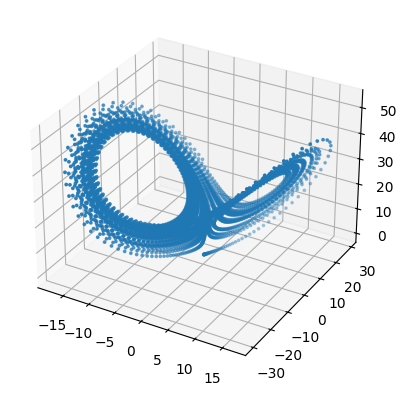

In [3]:
attr = Attractor("lorenz").rk4(0, 50, 5000)
df_lorenz = np.array([[i.X, i.Y, i.Z] for i in attr])
ax = plt.axes(projection="3d")
# ax.view_init(elev=20, azim=-70)
ax.scatter3D(df_lorenz.T[0], df_lorenz.T[1], df_lorenz.T[2], s=3)
plt.show()

In [4]:
class Dataset(Dataset):
   def __init__(self, data, targets=None):
       self.data = torch.from_numpy(data).float()

       self.targets = torch.from_numpy(targets).float() if targets is not None else None

   def __len__(self):
       return len(self.data)

   def __getitem__(self, idx):
       if self.targets is not None:
           return self.data[idx], self.targets[idx]
       else:
           return self.data[idx]

In [5]:
batch_size=256
lorenz_dataset = Dataset(df_lorenz)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
l_sz = 8

def get_encoder(d_input=3, d_latent=1, layer_sz=l_sz, alpha=1.0):
    encoder = nn.Sequential(
        nn.Linear(d_input, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_latent)
    )
    return encoder

def get_decoder(d_latent=1, d_output=3, layer_sz=l_sz, alpha=1.0):
    decoder = nn.Sequential(
        nn.Linear(d_latent, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_output)
    )
    return decoder

In [ ]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'gamma': trial.suggest_float('gamma', 0.1, 3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256])
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=params['batch_size'],
        shuffle=True
    )

    model = AutoEncoder(input_dim=3, latent_dim=1, hidden_dim=params['hidden_dim'], gamma=params['gamma']).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    criterion = nn.MSELoss()
    
    n_epochs = 2000
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step(total_loss)

        trial.report(total_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    recon = np.array(model(lorenz_dataset.data.to(device)).data.cpu())
    
    clear_output()

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)
    
    plt.show()

    return total_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = AutoEncoder(
    input_dim=3,
    latent_dim=1,
    hidden_dim=best_params['hidden_dim'],
    gamma=best_params['gamma']
).to(device)
best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

Best trial:
  Value:  8.334191557008028
  Params: 
    hidden_dim: 256
    learning_rate: 0.009031120355028437
    batch_size: 256


Loss: 136.93789148330688


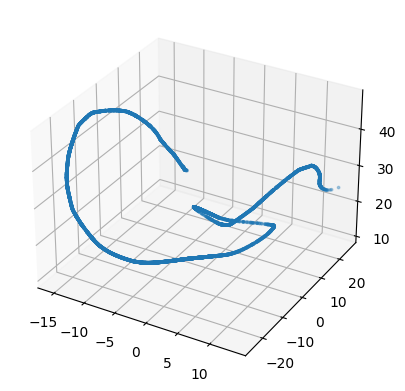

In [10]:
train_loader = DataLoader(
    lorenz_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    best_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

criterion = nn.MSELoss()

n_epochs = 2000
for epoch in range(n_epochs):
    best_model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        reconstructed = best_model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        best_optimizer.step()
        total_loss += loss.item()

    scheduler.step(total_loss)

recon = np.array(best_model(lorenz_dataset.data.to(device)).data.cpu())

clear_output()

ax = plt.axes(projection="3d")
ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)

print(f'Loss: {total_loss}')
plt.show()

In [11]:
class MultiHeadAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.encoder = get_encoder(input_dim, latent_dim, hidden_dim)
        self.decoders = nn.ModuleList([
            get_decoder(latent_dim, input_dim, hidden_dim) 
            for _ in range(num_heads)
        ])
        
    def forward(self, x):
        z = self.encoder(x)
        reconstructions = [decoder(z) for decoder in self.decoders]
        losses = [F.mse_loss(recon, x, reduction='none') for recon in reconstructions]
        losses = [loss.sum(dim=1) for loss in losses]
        losses_stack = torch.stack(losses, dim=1)
        best_head_idx = torch.argmin(losses_stack, dim=1)
        batch_size = x.size(0)
        reconstructions_stack = torch.stack(reconstructions, dim=1)
        best_reconstructions = reconstructions_stack[torch.arange(batch_size), best_head_idx]
        total_loss = torch.mean(losses_stack)
        
        return {
            'recon': best_reconstructions,
            'all_recons': reconstructions,
            'z': z,
            'loss': total_loss,
            'head_losses': losses_stack,
            'best_head_idx': best_head_idx
        }
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z, head_idx=None):
        if head_idx is None:
            return [decoder(z) for decoder in self.decoders]
        else:
            return self.decoders[head_idx](z)

Epoch 1500/1500:
MSE Loss: 39.7774


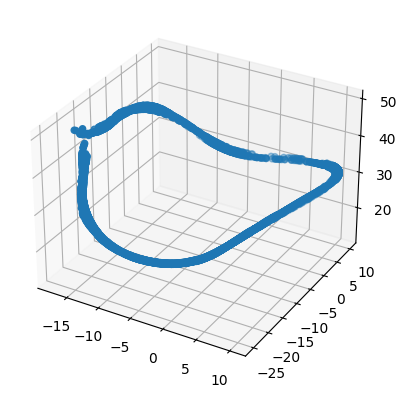

[I 2025-02-27 14:40:12,731] Trial 47 finished with value: 854.1223640441895 and parameters: {'hidden_dim': 128, 'learning_rate': 0.006777317735911826, 'batch_size': 256, 'num_heads': 8}. Best is trial 45 with value: 574.5971450805664.
[I 2025-02-27 14:40:12,924] Trial 48 pruned. 



Trial 48
Current parameters: {'hidden_dim': 128, 'learning_rate': 0.0031170323347062137, 'batch_size': 256, 'num_heads': 1}

Trial 49
Current parameters: {'hidden_dim': 128, 'learning_rate': 0.004668957809561153, 'batch_size': 256, 'num_heads': 7}


[I 2025-02-27 14:40:13,426] Trial 49 pruned. 


Best trial:
  Value:  574.5971450805664
  Params: 
    hidden_dim: 128
    learning_rate: 0.005101343069174701
    batch_size: 256
    num_heads: 8


In [12]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
        'num_heads': trial.suggest_int('num_heads', 1, 8)
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=params['batch_size'],
        shuffle=True
    )

    model = MultiHeadAutoencoder(
        input_dim=3,
        latent_dim=1,
        hidden_dim=params['hidden_dim'],
        num_heads=params['num_heads'],
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=1e-5
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    n_epochs = 1500
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            output['loss'].backward()
            optimizer.step()
            total_loss += output['loss'].item()

        scheduler.step(total_loss)

        trial.report(total_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    output = model(lorenz_dataset.data.to(device))
    recon = output['recon'].detach().cpu().numpy()

    clear_output()
    
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'MSE Loss: {output["loss"].mean():.4f}')

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2])
    
    plt.show()

    return total_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = MultiHeadAutoencoder(
    input_dim=3,
    latent_dim=1,
    hidden_dim=best_params['hidden_dim'],
    num_heads=best_params['num_heads'],
).to(device)

best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=1e-5
)

Epoch 5000/5000:
MSE Loss: 28.3809


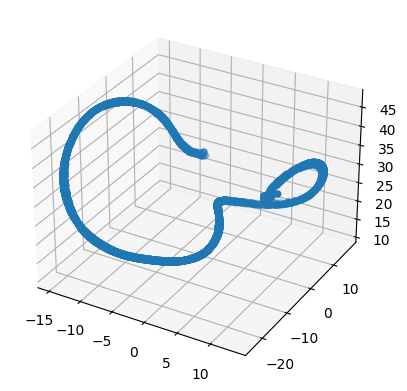

In [13]:
train_loader = DataLoader(
    lorenz_dataset,
    batch_size=256,
    shuffle=True
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    best_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

n_epochs = 5000
for epoch in range(n_epochs):
    best_model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        output = best_model(batch)
        output['loss'].backward()
        best_optimizer.step()
        total_loss += output['loss'].item()

    scheduler.step(total_loss)


output = best_model(lorenz_dataset.data.to(device))
recon = output['recon'].detach().cpu().numpy()

clear_output()

print(f'Epoch {epoch+1}/{n_epochs}:')
print(f'MSE Loss: {output["loss"].mean():.4f}')

ax = plt.axes(projection="3d")
ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2])

plt.show()